# A simple 2D Riemannian Flow Matching model on sphere

## Imports and init device

In [36]:
import os
import pandas
import time
import torch
import math
import numpy as np

from torch import nn, Tensor
import plotly.graph_objects as go

# flow_matching
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.solver import ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.utils.manifolds import Sphere, Manifold

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

In [37]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [38]:
torch.manual_seed(42)

## Dataset

In [39]:
import plotly.graph_objects as go
import pandas as pd
def plot_interactive_globe(points, classes=None, class_names=None):
    fig = go.Figure()
    
    lat = points[:,0]
    lon = points[:,1]
    
    if classes is not None:
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
        marker_color = classes
        colorscale = None
        
        unique_classes = sorted(np.unique(classes))
        if len(unique_classes) <= len(colors):
            colorscale = [[i/len(unique_classes), colors[i % len(colors)]] 
                            for i in range(len(unique_classes)+1)]
            
            if class_names is not None:
                fig = go.Figure()
                
                for i, class_id in enumerate(unique_classes):
                    class_id = int(class_id)
                    mask = classes == class_id
                    name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                    print(name)
                    
                    # Ensure we have points for this class
                    if np.any(mask):
                        fig.add_trace(go.Scattergeo(
                            lon=lon[mask],
                            lat=lat[mask],
                            mode='markers',
                            marker=dict(
                                size=5,
                                color=colors[i % len(colors)],
                                symbol='circle'
                            ),
                            name=name,
                            showlegend=True
                        ))
                
                # Skip the main trace addition below since we've added individual traces
                marker_color = None
    else:
        marker_color = 'red'
        colorscale = None
    
    # Add the main trace if we haven't added individual traces for the legend
    if marker_color is not None:
        fig.add_trace(go.Scattergeo(
            lon=lon,
            lat=lat,
            mode='markers',
            marker=dict(
                size=5, 
                color=marker_color,
                colorscale=colorscale,
                symbol='circle',
                showscale=classes is not None and class_names is None
            )
        ))
    
    fig.update_geos(
        projection_type="orthographic",  # Creates a globe effect
        showland=True,                   # Show landmasses
        landcolor="rgb(217, 217, 217)",  # Gray land color
        showocean=True,
        oceancolor="rgb(0, 102, 204)",   # Ocean color
        showlakes=True,
        lakecolor="rgb(0, 102, 204)",
        showcountries=True,              # Show country borders
        countrycolor="black"
    )
    
    fig.update_layout(
        title="Interactive 3D Globe with Data Points",
        geo=dict(
            showframe=False,             # Remove outer box
            showcoastlines=True,
            coastlinecolor="black"
        ),
        # Explicitly set legend properties to ensure visibility
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255, 255, 255, 0.8)",  # Semi-transparent background
            bordercolor="black",
            borderwidth=1,
            font=dict(size=12),
            itemsizing="constant"
        ),
        showlegend=True  # Explicitly enable legend
    )
    
    fig.show()

In [40]:
class EarthDataset(torch.utils.data.Dataset):
    """Some Information about EarthDataset"""
    def __init__(self):
        super(EarthDataset, self).__init__()
        path_dir = '../data/'
        files = ['volerup.csv', 'fire.csv', 'flood.csv', 'quakes_all.csv']
        self.class_names = ['Eruption', 'Fire', 'Flood', 'Earthquake']
        skip_header = [2, 1, 2, 4]
        data_arr = []
        conds_arr = []
        for i, (f, head) in enumerate(zip(files, skip_header)):
            data = np.genfromtxt(os.path.join(path_dir, f), delimiter=",", skip_header=head)
            data_arr.append(data)
            conds_arr.append(np.ones(data.shape[0]) * i)
        
        self.data = self.lat_long_to_cartesian(np.concat(data_arr, axis=0))
        print(self.data)
        self.conds = np.concat(conds_arr, axis=0)

    def __getitem__(self, index):
        return self.data[index], self.conds[index]

    def __len__(self):
        return len(self.data)


    def lat_long_to_cartesian(self, raw_data):
        data_normalized= raw_data/180 * np.pi
        colat = np.pi / 2 - data_normalized[:,0]
        long = data_normalized[:,1] + np.pi
        return np.stack(
            [
                np.sin(colat) * np.cos(long),
                np.sin(colat) * np.sin(long),
                np.cos(colat),
            ],
            axis=-1,
        )

    def cartesian_to_lat_long(self, points):
        long = np.arctan2(points[:, 1], points[:, 0])
        long = np.where(long < 0, long + 2 * np.pi, long)
        colat = np.arccos(points[:, 2])
        lon = long - np.pi
        lat = np.pi/2 - colat
        converted =  np.stack([lat, lon], axis=-1)
        return converted / np.pi * 180

ds = EarthDataset()
plot_interactive_globe(ds.cartesian_to_lat_long(ds.data), classes=ds.conds, class_names=ds.class_names)

[[ 0.86396667  0.02307645 -0.50301995]
 [ 0.5554533  -0.65543172  0.511743  ]
 [-0.06549387  0.97601065  0.20763853]
 ...
 [-0.60843051 -0.49412313  0.62101099]
 [-0.55960721 -0.54737682  0.62226874]
 [-0.17136365 -0.74857321  0.64052529]]
Eruption
Fire
Flood
Earthquake


In [41]:
# def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
#     x1 = torch.rand(batch_size, device=device) * 4 - 2
#     x2_ = (torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2)
#     x2 = x2_ + (torch.floor(x1) % 2)

#     data = torch.cat([x1[:, None], x2[:, None]], dim=1)

#     return data.float()

def wrap(manifold, samples):
    center = torch.cat([torch.zeros_like(samples), torch.ones_like(samples[..., 0:1])], dim=-1)
    samples = torch.cat([samples, torch.zeros_like(samples[..., 0:1])], dim=-1) / 2

    return manifold.expmap(center, samples)

## Model

In [54]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


# Model class
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 2,
        time_dim: int = 1,
        cond_dim: int = 1,
        hidden_dim: int = 256,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.input_layer = nn.Linear(input_dim + time_dim + cond_dim, hidden_dim)

        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor, cond : Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t, cond.view(-1,1).float()], dim=1)
        h = self.input_layer(h)
        output = self.main(h)

        return output.reshape(*sz)


class ProjectToTangent(nn.Module):
    """Projects a vector field onto the tangent plane at the input."""

    def __init__(self, vecfield: nn.Module, manifold: Manifold):
        super().__init__()
        self.vecfield = vecfield
        self.manifold = manifold

    def forward(self, x: Tensor, t: Tensor, cond) -> Tensor:
        x = self.manifold.projx(x)
        v = self.vecfield(x, t, cond)
        v = self.manifold.proju(x, v)
        return v

## Train Velocity Flow Matching model

In [55]:
# training arguments
lr = 0.001
batch_size = 2048
iterations = 10001
print_every = 1000
manifold = Sphere()
dim = 3
hidden_dim = 512

# velocity field model init
vf = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=dim,
        hidden_dim=hidden_dim,
    ),
    manifold=manifold,
)
vf.to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
k = 0
keep_going = True
while keep_going:
    dl = dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)
    for (data,cond) in dl:
        k+=1
        if k > iterations:
            keep_going = False
            break
        optim.zero_grad() 

        cond = cond.to(device).float()
        x_1 = data.to(device).float()
        x_0 = torch.randn_like(x_1[:,:-1]).to(device)
        x_0 = wrap(manifold, x_0)

        t = torch.rand(x_1.shape[0]).to(device) 

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        loss = torch.pow( vf(path_sample.x_t,path_sample.t, cond) - path_sample.dx_t, 2).mean()

        # optimizer step
        loss.backward() # backward
        optim.step() # update
        
        # log loss
        if (k+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(k+1, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()

| iter   1000 | 12.35 ms/step | loss    0.403 
| iter   2000 | 12.40 ms/step | loss    0.378 
| iter   3000 | 12.48 ms/step | loss    0.399 
| iter   4000 | 12.62 ms/step | loss    0.379 
| iter   5000 | 12.67 ms/step | loss    0.393 
| iter   6000 | 12.60 ms/step | loss    0.383 
| iter   7000 | 12.67 ms/step | loss    0.397 
| iter   8000 | 12.79 ms/step | loss    0.392 
| iter   9000 | 12.75 ms/step | loss    0.372 
| iter  10000 | 12.76 ms/step | loss    0.389 


#### Sample from trained model

In [56]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x=x, t=t, **extras)

wrapped_vf = WrappedModel(vf)

In [62]:
# step size for ode solver
step_size = 0.01
N = 6

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 5000  # batch size
eps_time = 1e-2
T = torch.linspace(0, 1, N)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
x_init = wrap(manifold, x_init)
cond = torch.randint(0, 4, (batch_size,), device=device)

solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class
sol = solver.sample(
    x_init=x_init,
    step_size=step_size,
    method="midpoint",
    return_intermediates=True,
    time_grid=T,
    verbose=True,
    cond=cond,
)
print(len(ds))

100%|██████████| 100/100 [00:00<00:00, 412.12it/s]

24631


### Visualize the path

In [63]:
sol = sol.cpu()
T = T.cpu()

plot_interactive_globe(ds.cartesian_to_lat_long(sol[-1]), classes=cond.cpu().numpy(), class_names=ds.class_names)

Eruption
Fire
Flood
Earthquake


/tmp/ipykernel_692047/756523669.py:41: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipykernel_692047/756523669.py:43: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



torch.Size([6, 1000, 3])


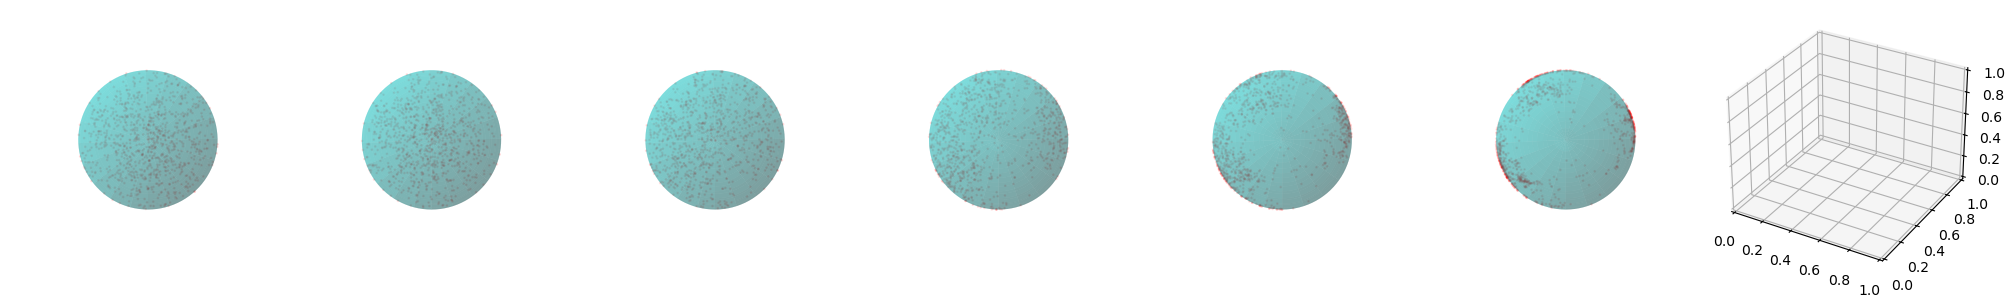

In [61]:
sol = sol.cpu()
T = T.cpu()

# gt_samples = inf_train_gen(batch_size=50000)  # sample data
# gt_samples = wrap(manifold, gt_samples)

# samples = torch.cat([sol, gt_samples[None]], dim=0).numpy()
samples = sol
print(samples.shape)


_, axs = plt.subplots(1, N + 1, figsize=(20, 3.2), subplot_kw={"projection": "3d"})

for i in range(samples.shape[0]):
    # Sphere parameters (theta: azimuth, phi: polar angle)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    # Parametric equations for the sphere
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot the surface of the sphere
    axs[i].plot_surface(x, y, z, color="c", alpha=0.3, rstride=5, cstride=5)

    # Plot only the visible points on the front side of the sphere
    x_points, y_points, z_points = (
        samples[i, :, 0],
        samples[i, :, 1],
        samples[i, :, 2],
    )
    axs[i].scatter(
        x_points, y_points, z_points, color="r", s=1, alpha=0.1
    )  # Red points

    # Set labels
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_zlabel("Z")

    # Set the aspect ratio to equal for better visualization of a sphere
    axs[i].set_box_aspect([1, 1, 1])
    axs[i].view_init(elev=90, azim=0)
    axs[i].axis("off")

plt.tight_layout()
plt.show()